# Detecting Sarcasm - Classification

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import re

import spacy
nlp = spacy.load('en_core_web_sm')
# pip install https://github.com/explosion/spacy-models/releases/download/en_core_web_sm-2.3.1/en_core_web_sm-2.3.1.tar.gz --no-deps

In [2]:
reddit = pd.read_csv('train-balanced-sarcasm-trimmed.csv')

In [4]:
reddit = reddit[reddit['comment'].notna()]
reddit.groupby('label')['comment'].count()

label
0    25000
1    25000
Name: comment, dtype: int64

In [5]:
# Load preprocessing libraries
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import FeatureUnion, Pipeline
from sklearn.preprocessing import FunctionTransformer

In [6]:
y = reddit['label']
X = reddit['comment']

In [8]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30)

In [9]:
from num2words import num2words

def normalize_text(comment):
    comment = comment.str.replace(r'[^\w\s]', '')
    comment = comment.str.lower()
    
    def convert_num_to_words(text):
        return ' '.join([num2words(i) if i.isdigit() else i for i in text.split()])
    
    comment = comment.apply(lambda x: convert_num_to_words(x)) 
    return(comment)

In [10]:
lemma_nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])

def lemmatize_text(comment):
    comment = comment.apply(lambda x: ' '.join([token.lemma_ for token in lemma_nlp(x)]))
    return(comment)

In [12]:
def get_comment_length(x):
    return np.array([len(t.split()) for t in x]).reshape(-1, 1)

def count_ellipsis(x):
    return np.array([t.count('...') for t in x]).reshape(-1, 1)

def count_exclamations(x):
    return np.array([t.count('!') for t in x]).reshape(-1, 1)

def count_question_mark(x):
    return np.array([t.count('?') for t in x]).reshape(-1, 1)

def count_quotation_mark(x):
    return np.array([t.count('"') for t in x]).reshape(-1, 1)

def count_smiley(x):
    return np.array([t.count(':)') for t in x]).reshape(-1, 1)

def get_repeating_chars(x):
    repeating_chars = [list(match[0] for match in re.findall(r'((\w)\2{2,})', string)) for string in x]
    repeating_chars_list = []
    for each in repeating_chars:
        if not each:
            repeating_chars_list.append(0)
        else:
            repeating_chars_list.append(len(max(each)))
    return np.array(repeating_chars_list).reshape(-1, 1)

In [13]:
# Pipeline to bind 

feature_union = FeatureUnion([('bag_of_ngrams', Pipeline([
                                                          ('normalize', FunctionTransformer(normalize_text)),
                                                          ('lemmatize', FunctionTransformer(lemmatize_text)),
                                                          ('tfidf_vec', TfidfVectorizer(ngram_range=(1,2))),      
                                                         ])),
                              ('additional_features', FeatureUnion([
                                                                    ('count',FunctionTransformer(get_comment_length)),
                                                                    ('ellipsis',FunctionTransformer(count_ellipsis)),
                                                                    ('exclamation',FunctionTransformer(count_exclamations)),
                                                                    ('question_mark',FunctionTransformer(count_question_mark)),
                                                                    ('quotation_mark',FunctionTransformer(count_quotation_mark)),
                                                                    ('smiley',FunctionTransformer(count_smiley)),
                                                                    ('repeating_char',FunctionTransformer(get_repeating_chars)),
                                                                   ]))
                             ])

In [73]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.ensemble import GradientBoostingClassifier, StackingClassifier

from sklearn.model_selection import KFold, cross_val_score
from sklearn.metrics import confusion_matrix, classification_report, make_scorer, f1_score, roc_curve, roc_auc_score

### Create benchmark models and compare f1 and accuracy scores

The benchmark models consist of five classifiers: Multinomial Naive Bayes, Logistic Regression, Decision Tree, Linear SVM, and the Gradient Boosting classifier. They are trained on the bag-of-ngrams feature set only (specifically unigram and bigrams) with no preprocessing or feature engineering steps applied.

In [53]:
# Create classifiers to loop throug

classifiers = [('Naive Bayes', Pipeline([
                                         ('tfidf_vec', TfidfVectorizer(ngram_range=(1,2))), 
                                         ('clf', MultinomialNB())
                                        ])),
               ('Logistic Regression', Pipeline([
                                                 ('tfidf_vec', TfidfVectorizer(ngram_range=(1,2))), 
                                                 ('clf', LogisticRegression(solver='lbfgs', max_iter=4000))
                                                ])),
               ('Decision Tree', Pipeline([
                                           ('tfidf_vec', TfidfVectorizer(ngram_range=(1,2))), 
                                           ('clf', DecisionTreeClassifier())
                                          ])),
               ('Linear SVM', Pipeline([
                                        ('tfidf_vec', TfidfVectorizer(ngram_range=(1,2))), 
                                        ('clf', SGDClassifier())
                                       ])),
               ('Gradient Boosting', Pipeline([
                                               ('tfidf_vec', TfidfVectorizer(ngram_range=(1,2))), 
                                               ('clf', GradientBoostingClassifier())
                                              ]))
              ]

In [51]:
# Create custom metric of f1-score of the sarcastic class, labelled '1'. 
f1_scorer = make_scorer(f1_score, pos_label=1)

# Use 5 folds for cross validation. 
kfold = KFold(n_splits=5, shuffle=True)

In [54]:
f1, accuracy, names  = [], [], []
for name, classifier in classifiers:
    
    # Use 3-fold CV to obtain accuracy scores and f1-score of sarcastic class for each classifier
    f1_scores = cross_val_score(classifier, X_train, y_train, cv=kfold, scoring=f1_scorer)
    accuracy_scores = cross_val_score(classifier, X_train, y_train, cv=kfold, scoring='accuracy')
    print('%s f1-score: %.2f%%, accuracy: %.2f%%' % (name, 100*f1_scores.mean(), 100*accuracy_scores.mean()))
    
    # Fill lists with scores for boxplot visualization
    f1.append(f1_scores)
    accuracy.append(accuracy_scores)
    names.append(name)

Naive Bayes f1-score: 66.74%, accuracy: 66.43%
Logistic Regression f1-score: 66.07%, accuracy: 67.39%
Decision Tree f1-score: 58.69%, accuracy: 59.58%
Linear SVM f1-score: 63.52%, accuracy: 67.03%
Gradient Boosting f1-score: 55.55%, accuracy: 62.88%


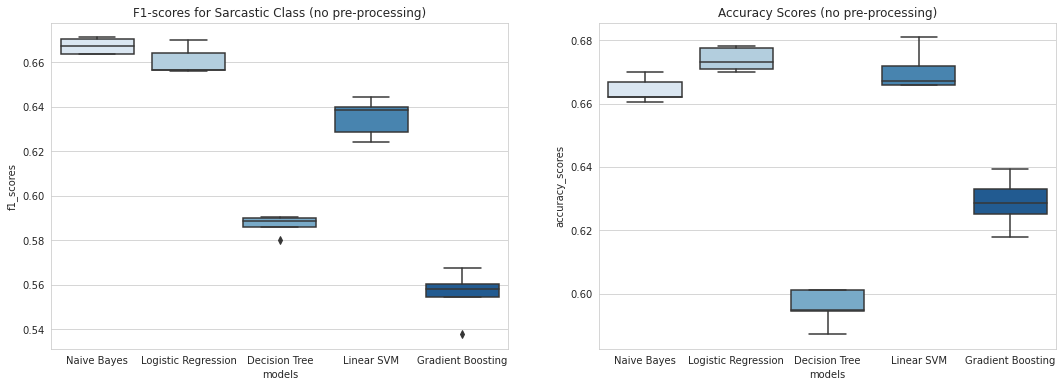

In [63]:
sns.set_style('whitegrid')

models = [y for x in names for y in (x,)*5]
f1_scores = [item for sublist in f1 for item in sublist]
accuracy_scores = [item for sublist in accuracy for item in sublist]
df_f1 = pd.DataFrame({'models':models, 'f1_scores':f1_scores})
df_accuracy = pd.DataFrame({'models':models, 'accuracy_scores':accuracy_scores})

fig, (ax1, ax2) = plt.subplots(1,2, figsize=(18,6))
sns.boxplot(x='models', y='f1_scores', data=df_f1, palette='Blues', ax=ax1)
ax1.set_title('F1-scores for Sarcastic Class (no pre-processing)')
sns.boxplot(x='models', y='accuracy_scores', data=df_accuracy, palette='Blues', ax=ax2)
ax2.set_title('Accuracy Scores (no pre-processing)');

### Cross validate models trained on preprocessed and feature engineered data via pipeline

In [64]:
classifiers = [('Naive Bayes', Pipeline([
                                         ('features', feature_union),
                                         ('clf', MultinomialNB())
                                        ])),
               ('Logistic Regression', Pipeline([
                                                 ('features', feature_union), 
                                                 ('clf', LogisticRegression(solver='lbfgs', max_iter=4000))
                                                ])),
               ('Decision Tree', Pipeline([
                                           ('features', feature_union), 
                                           ('clf', DecisionTreeClassifier())
                                          ])),
               ('Linear SVM', Pipeline([
                                        ('features', feature_union), 
                                        ('clf', SGDClassifier())
                                       ])),
               ('Gradient Boosting', Pipeline([
                                               ('features', feature_union), 
                                               ('clf', GradientBoostingClassifier())
                                              ]))
              ]

In [66]:
f1, accuracy, names  = [], [], []
for name, classifier in classifiers:
    
    # Use 3-fold CV to obtain accuracy scores and f1-score of sarcastic class for each classifier
    f1_scores = cross_val_score(classifier, X_train, y_train, cv=kfold, scoring=f1_scorer)
    accuracy_scores = cross_val_score(classifier, X_train, y_train, cv=kfold, scoring='accuracy')
    print('%s f1-score: %.2f%%, accuracy: %.2f%%' % (name, 100*f1_scores.mean(), 100*accuracy_scores.mean()))
    
    # Fill lists with scores for boxplot visualization
    f1.append(f1_scores)
    accuracy.append(accuracy_scores)
    names.append(name)

Naive Bayes f1-score: 62.71%, accuracy: 65.60%
Logistic Regression f1-score: 66.39%, accuracy: 67.12%
Decision Tree f1-score: 59.07%, accuracy: 60.21%
Linear SVM f1-score: 60.06%, accuracy: 60.80%
Gradient Boosting f1-score: 57.39%, accuracy: 64.57%


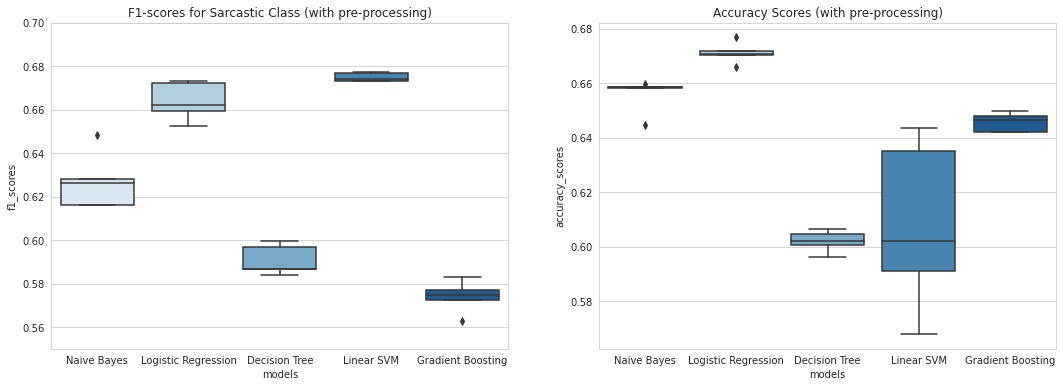

In [77]:
sns.set_style('whitegrid')

models = [y for x in names for y in (x,)*5]
f1_scores = [item for sublist in f1 for item in sublist]
accuracy_scores = [item for sublist in accuracy for item in sublist]
df_f1 = pd.DataFrame({'models':models, 'f1_scores':f1_scores})
df_accuracy = pd.DataFrame({'models':models, 'accuracy_scores':accuracy_scores})

fig, (ax1, ax2) = plt.subplots(1,2, figsize=(18,6))
sns.boxplot(x='models', y='f1_scores', data=df_f1, palette='Blues', ax=ax1)
ax1.set_title('F1-scores for Sarcastic Class (with pre-processing)')
ax1.set_ylim(0.55,0.7)
sns.boxplot(x='models', y='accuracy_scores', data=df_accuracy, palette='Blues', ax=ax2)
ax2.set_title('Accuracy Scores (with pre-processing)');

In [14]:
# Bind text preprocessing and classifier in pipeline

nb_multi_classifier = Pipeline([('features', feature_union),
                                ('clf', MultinomialNB())
                               ])

In [15]:
nb_multi_classifier.fit(X_train, y_train)

Pipeline(steps=[('features',
                 FeatureUnion(transformer_list=[('bag_of_ngrams',
                                                 Pipeline(steps=[('normalize',
                                                                  FunctionTransformer(func=<function normalize_text at 0x7fafb9a413b0>)),
                                                                 ('lemmatize',
                                                                  FunctionTransformer(func=<function lemmatize_text at 0x7fafb9a41dd0>)),
                                                                 ('tfidf_vec',
                                                                  TfidfVectorizer(ngram_range=(1,
                                                                                               2)))])),
                                                ('additional_features',
                                                 FeatureUnion(transfor...
                                            

In [16]:
nb_multi_predict = nb_multi_classifier.predict(X_test)

              precision    recall  f1-score   support

           0       0.65      0.74      0.69      7382
           1       0.71      0.61      0.65      7618

    accuracy                           0.67     15000
   macro avg       0.68      0.67      0.67     15000
weighted avg       0.68      0.67      0.67     15000





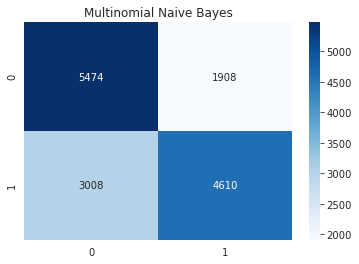

In [78]:
print(classification_report(y_test, nb_multi_predict))
print('\n')
sns.heatmap(confusion_matrix(y_test, nb_multi_predict), annot=True, cmap='Blues', fmt='g')
plt.title("Multinomial Naive Bayes");

In [18]:
dtree_classifier = Pipeline([('features', feature_union),
                             ('clf', DecisionTreeClassifier())])

In [19]:
dtree_classifier.fit(X_train, y_train)

Pipeline(steps=[('features',
                 FeatureUnion(transformer_list=[('bag_of_ngrams',
                                                 Pipeline(steps=[('normalize',
                                                                  FunctionTransformer(func=<function normalize_text at 0x7fafb9a413b0>)),
                                                                 ('lemmatize',
                                                                  FunctionTransformer(func=<function lemmatize_text at 0x7fafb9a41dd0>)),
                                                                 ('tfidf_vec',
                                                                  TfidfVectorizer(ngram_range=(1,
                                                                                               2)))])),
                                                ('additional_features',
                                                 FeatureUnion(transfor...
                                            

              precision    recall  f1-score   support

           0       0.60      0.63      0.61      7382
           1       0.62      0.59      0.60      7618

    accuracy                           0.61     15000
   macro avg       0.61      0.61      0.61     15000
weighted avg       0.61      0.61      0.61     15000





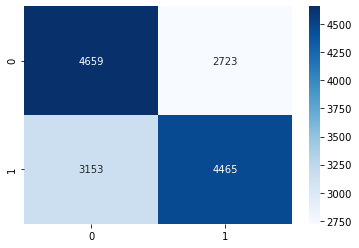

In [20]:
dtree_predict = dtree_classifier.predict(X_test)

print(classification_report(y_test, dtree_predict))
print('\n')
sns.heatmap(confusion_matrix(y_test, dtree_predict), annot=True, cmap='Blues', fmt='g');

In [21]:
lr_classifier = Pipeline([('features', feature_union),
                          ('clf', LogisticRegression(solver='lbfgs', max_iter=4000))
                         ])

lr_classifier.fit(X_train, y_train)

Pipeline(steps=[('features',
                 FeatureUnion(transformer_list=[('bag_of_ngrams',
                                                 Pipeline(steps=[('normalize',
                                                                  FunctionTransformer(func=<function normalize_text at 0x7fafb9a413b0>)),
                                                                 ('lemmatize',
                                                                  FunctionTransformer(func=<function lemmatize_text at 0x7fafb9a41dd0>)),
                                                                 ('tfidf_vec',
                                                                  TfidfVectorizer(ngram_range=(1,
                                                                                               2)))])),
                                                ('additional_features',
                                                 FeatureUnion(transfor...
                                            

              precision    recall  f1-score   support

           0       0.67      0.71      0.69      7382
           1       0.70      0.67      0.68      7618

    accuracy                           0.69     15000
   macro avg       0.69      0.69      0.69     15000
weighted avg       0.69      0.69      0.69     15000





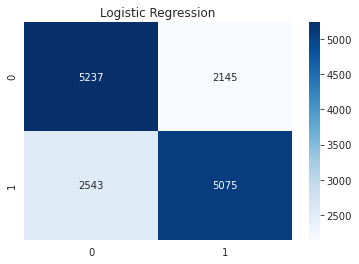

In [79]:
lr_predit = lr_classifier.predict(X_test)

print(classification_report(y_test, lr_predit))
print('\n')
sns.heatmap(confusion_matrix(y_test, lr_predit), annot=True, cmap='Blues', fmt='g');
plt.title("Logistic Regression");

In [25]:
svm_classifier = Pipeline([('features', feature_union),
                           ('clf', SGDClassifier())
                          ])

svm_classifier.fit(X_train, y_train)

Pipeline(steps=[('features',
                 FeatureUnion(transformer_list=[('bag_of_ngrams',
                                                 Pipeline(steps=[('normalize',
                                                                  FunctionTransformer(func=<function normalize_text at 0x7fafb9a413b0>)),
                                                                 ('lemmatize',
                                                                  FunctionTransformer(func=<function lemmatize_text at 0x7fafb9a41dd0>)),
                                                                 ('tfidf_vec',
                                                                  TfidfVectorizer(ngram_range=(1,
                                                                                               2)))])),
                                                ('additional_features',
                                                 FeatureUnion(transfor...
                                            

              precision    recall  f1-score   support

           0       0.71      0.31      0.43      7382
           1       0.57      0.88      0.69      7618

    accuracy                           0.60     15000
   macro avg       0.64      0.59      0.56     15000
weighted avg       0.64      0.60      0.56     15000





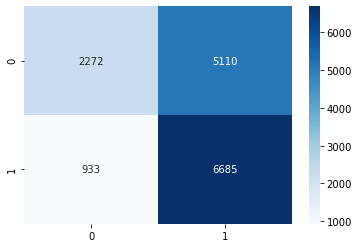

In [26]:
svm_predit = svm_classifier.predict(X_test)

print(classification_report(y_test, svm_predit))
print('\n')
sns.heatmap(confusion_matrix(y_test, svm_predit), annot=True, cmap='Blues', fmt='g');

In [28]:
gb_classifier = Pipeline([('features', feature_union),
                          ('clf', GradientBoostingClassifier())
                          ])

gb_classifier.fit(X_train, y_train)

Pipeline(steps=[('features',
                 FeatureUnion(transformer_list=[('bag_of_ngrams',
                                                 Pipeline(steps=[('normalize',
                                                                  FunctionTransformer(func=<function normalize_text at 0x7fafb9a413b0>)),
                                                                 ('lemmatize',
                                                                  FunctionTransformer(func=<function lemmatize_text at 0x7fafb9a41dd0>)),
                                                                 ('tfidf_vec',
                                                                  TfidfVectorizer(ngram_range=(1,
                                                                                               2)))])),
                                                ('additional_features',
                                                 FeatureUnion(transfor...
                                            

              precision    recall  f1-score   support

           0       0.60      0.81      0.69      7382
           1       0.73      0.49      0.58      7618

    accuracy                           0.65     15000
   macro avg       0.67      0.65      0.64     15000
weighted avg       0.67      0.65      0.64     15000





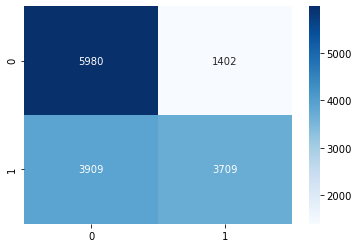

In [29]:
gb_predit = gb_classifier.predict(X_test)

print(classification_report(y_test, gb_predit))
print('\n')
sns.heatmap(confusion_matrix(y_test, gb_predit), annot=True, cmap='Blues', fmt='g');

## Model Evaluation using AUC Score

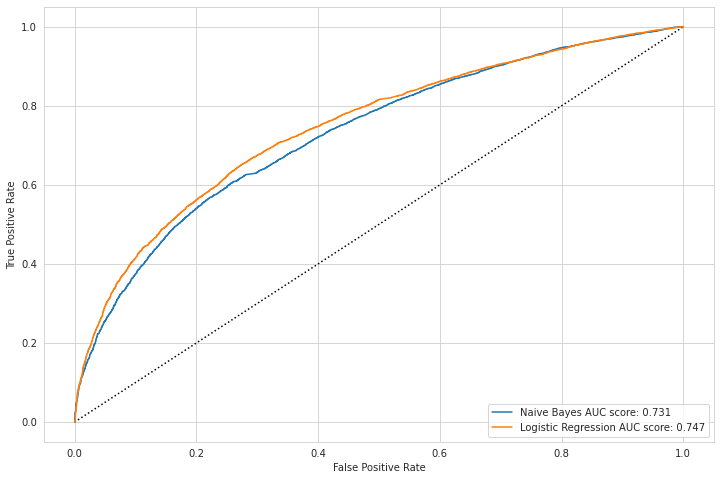

In [76]:
# Create ROC curves from classification probabilities using predict_proba

nb_predictions = nb_multi_classifier.predict_proba(X_test)[:,1]
fpr_nb, tpr_nb, _ = roc_curve(y_test, nb_predictions, pos_label=1)

lr_predictions = lr_classifier.predict_proba(X_test)[:,1]
fpr_lr, tpr_lr, _ = roc_curve(y_test, lr_predictions, pos_label=1)

# Calculate auc scores 
auc_nb = roc_auc_score(y_test, nb_predictions)
auc_lr = roc_auc_score(y_test, lr_predictions)

# Plot ROC curves
plt.figure(figsize=(12,8))
plt.plot([0, 1], [0, 1], linestyle=':', color='k')
plt.plot(fpr_nb, tpr_nb, label=('Naive Bayes AUC score: %.3f' % auc_nb))
plt.plot(fpr_lr, tpr_lr, label=('Logistic Regression AUC score: %.3f' % auc_lr))
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc=4)
plt.show()

## Bonus: Stacked classifier using Linear SVM and Gradient Boosting classifier

In [40]:
from sklearn.pipeline import make_pipeline
from sklearn.ensemble import StackingClassifier

In [45]:
classifiers = [('rf', SGDClassifier()),
               ('svr', GradientBoostingClassifier())]

stacked_classifier = Pipeline([('features', feature_union),
                               ('clf', StackingClassifier(estimators=classifiers, final_estimator=LogisticRegression()))])

stacked_classifier.fit(X_train, y_train)

Pipeline(steps=[('features',
                 FeatureUnion(transformer_list=[('bag_of_ngrams',
                                                 Pipeline(steps=[('normalize',
                                                                  FunctionTransformer(func=<function normalize_text at 0x7fafb9a413b0>)),
                                                                 ('lemmatize',
                                                                  FunctionTransformer(func=<function lemmatize_text at 0x7fafb9a41dd0>)),
                                                                 ('tfidf_vec',
                                                                  TfidfVectorizer(ngram_range=(1,
                                                                                               2)))])),
                                                ('additional_features',
                                                 FeatureUnion(transfor...
                                            

              precision    recall  f1-score   support

           0       0.62      0.80      0.69      7382
           1       0.72      0.52      0.61      7618

    accuracy                           0.66     15000
   macro avg       0.67      0.66      0.65     15000
weighted avg       0.67      0.66      0.65     15000





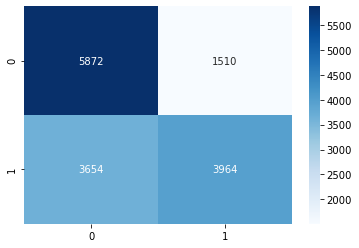

In [46]:
stacked_predit = stacked_classifier.predict(X_test)

print(classification_report(y_test, stacked_predit))
print('\n')
sns.heatmap(confusion_matrix(y_test, stacked_predit), annot=True, cmap='Blues', fmt='g');